In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
from pylcp.atom import atom
import scipy.constants as cts
from numpy import random as rnd
from pylcp.common import progressBar
import pandas as pd


In [3]:
def sat(wavenumber, gamma):

    wavelength = 1 / (wavenumber * 100)
    
    # Saturation intensity formula
    return np.pi * cts.c* cts.h * gamma / (3 * wavelength**3)

wavenumber = 25068.222  # Wavenumber in cm^-1
gamma = 1.93e8  # Decay rate in s^-1
Isat = sat(wavenumber, gamma)
print(Isat)
Isat*1*(((12*1e-3)**2)*np.pi/2)*1e3

632.4602794347063


143.05914486427832

In [4]:
def v_avg(m,T):
    return np.sqrt(8*cts.k*T/(np.pi*m))

In [5]:
mass_lab = 173*cts.value('atomic mass constant') # YB-173 mass in kg
v_a = v_avg(mass_lab,216.85)
sd = np.sqrt(cts.k*216.85/mass_lab)
vel = np.random.normal(v_a,sd,1000000)
klab = 2*np.pi*25068.2222# Lab wavevector (without 2pi) in cm^{-1}   # Lifetime of 6P_{3/2} state (in seconds)
gammalab = (1.93*1e8)
v0 =max(vel)
Blab = -2*67*1e-3#(v0*cts.hbar*(klab*100))/cts.value('Bohr magneton')
b_0L = 2*67*1e-3 
# (v0*cts.hbar*(klab*100))/cts.value('Bohr magneton')/2
# T # About 15 G/cm is a typical gradient for Rb
L = 16#100*(mass_lab*(v0**2))/(0.5*cts.hbar*(klab*100)*gammalab) +5
print(Blab, L,v0,b_0L)

-0.134 16 642.8167334831118 0.134


In [6]:
# Now, here are our `natural' length and time scales:
x0 = 1/klab  # cm
t0 = 1/gammalab  # s

mass = mass_lab*(x0*1e-2)**2/cts.hbar/t0

# And now our wavevector, decay rate, and magnetic field gradient in these units:
k = klab*x0
gamma = gammalab*t0
alpha = cts.value('Bohr magneton')*Blab*t0/cts.hbar
b_0 = cts.value('Bohr magneton')*b_0L*t0/cts.hbar 
l = L/x0 

print(x0, t0, mass, k, gamma, alpha,b_0)

6.348872362073421e-06 5.181347150259067e-09 2119.188266564296 1.0 1.0 -61.05748223883164 61.05748223883164


In [7]:
def mag(R,B_0):
  for i in R:
    if i > l:
        return 0
    else: 
        return B_0 +alpha*(np.sqrt(1-R/l))

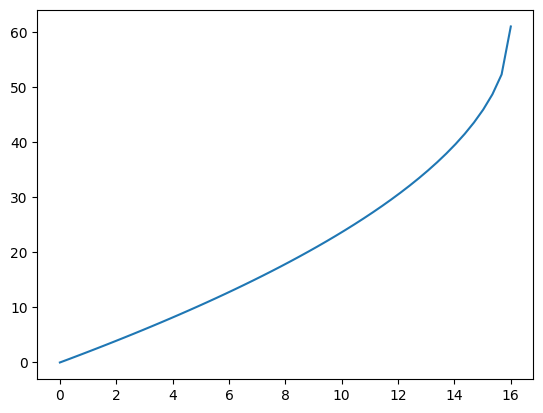

In [8]:
x = np.linspace(0,l)
plt.plot(x*x0,mag(x,b_0))

In [9]:
# Define the atomic Hamiltonian:
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
0, 5/2, 0,  	-0.2592,
    Ahfs = 0, Bhfs=0, Chfs=0,
    muB=1)# ground state 1s0
H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
1, 5/2, 1.035,	-0.2592,
    Ahfs=59.52*1e6,Bhfs = 601.87*1e6 , Chfs= 0,
    muB=1) #excited state 1p1

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(0, 1, 5/2)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))
hamiltonian_D2 = pylcp.hamiltonian(mass = mass)
hamiltonian_D2.add_H_0_block('g', H_g_D2)
hamiltonian_D2.add_H_0_block('e', H_e_D2)
hamiltonian_D2.add_d_q_block('g', 'e', dijq_D2, gamma = gamma, k = k)
hamiltonian_D2.add_mu_q_block('g', mu_q_g_D2)
hamiltonian_D2.add_mu_q_block('e', mu_q_e_D2)


dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)

#ham = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq, mass=mass, gamma=gamma, k=k)
vc = x0/t0*1/(100)
det = -(k*v0/vc +b_0)/2
s = 0.3

# Define the laser beams:
laserBeams = pylcp.laserBeams([
     {'kvec':np.array([-1., 0., 0.]), 's': s, 'pol': 1, 'delta': (E_e_D2[2]-E_g_D2[0]) + det*gamma},],
    beam_type=pylcp.infinitePlaneWaveBeam)
# Define the magnetic field:
linGrad = lambda R: mag(R,b_0)

In [10]:
det

-56.75904203133898

In [11]:
rateeq = pylcp.rateeq(laserBeams, linGrad, hamiltonian_D2, include_mag_forces = False)

In [22]:
x = np.arange(0, L, 0.4)/(x0)
v = np.arange(0, 800,10)/vc


X, V = np.meshgrid(x, v)

Rvec = np.array([X, np.zeros(X.shape), np.zeros(X.shape)])
Vvec = np.array([V, np.zeros(V.shape), np.zeros(V.shape)])

rateeq.generate_force_profile(Rvec, Vvec, name='Fx', progress_bar=True)

Completed in 2.26 s.                                               


C:\Users\benfo\AppData\Local\Temp\ipykernel_18240\1573788171.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = plt.cm.get_cmap('viridis_r')


Text(0.5, 1.0, 'Contour plot of position vs velocity and force')

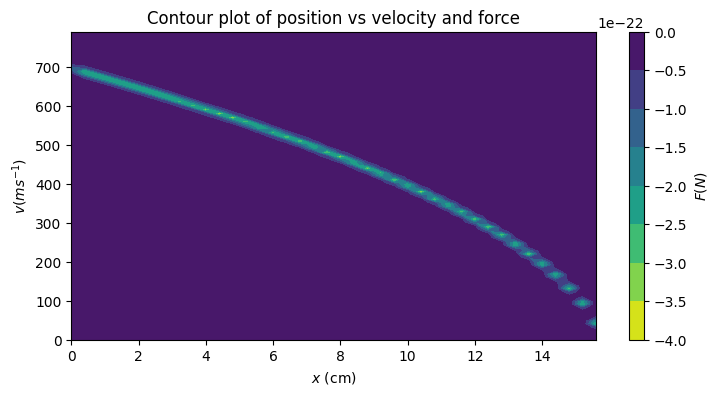

In [23]:
Fc = cts.hbar*klab*gammalab
fig,ax = plt.subplots(1, 1, figsize=(8, 4)) 
cmap_reversed = plt.cm.get_cmap('viridis_r')
Fc = gammalab*cts.hbar*klab
im1 = ax.contourf(np.array(x)*x0, np.array(v)*vc, rateeq.profile['Fx'].F[0]*Fc, cmap =cmap_reversed)
fig.subplots_adjust(left=0.08, wspace=0.2)
cb1 = plt.colorbar(im1)
cb1.set_label('$F(N)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v (ms^{-1})$')
plt.title('Contour plot of position vs velocity and force')

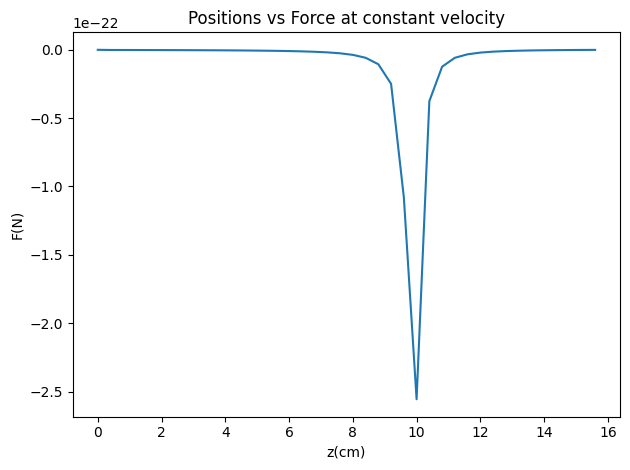

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, num="Expression",sharey = False)
ax.plot(np.array(x)*x0, rateeq.profile['Fx'].F[0][int(len(v)/2),:]*Fc)
ax.set_xlabel('z(cm)')
ax.set_ylabel('F(N)')
plt.title('Positions vs Force at constant velocity')
plt.tight_layout()

code below plots dynamics directly from pylcp  found this was too slow

In [91]:
# # %% Now try to evolve some initial state!

# rateeq.v0 = np.array([600/vc, 0., 0.])
# rateeq.r0 = ([0,0,0])
# n0 = np.zeros(rateeq.hamiltonian.n)
# n0[0] = 1
# rateeq.set_initial_pop(n0)

# t_span = [0, 0.0013/t0]


# rateeq.evolve_motion(t_span,
# #                   progress_bar=True,
#                   random_recoil=False
#                  );

In [92]:
# fig,ax = plt.subplots(1,2, figsize=(8,4))
# ax[0].plot(rateeq.sol.t*t0*1e3,rateeq.sol.r[0]*x0)
# ax[1].plot(rateeq.sol.t*t0*1e3,rateeq.sol.v[0]*vc)
# ax[0].set_xlabel('t (ms)')
# ax[0].set_ylabel('z (cm)')
# ax[1].set_xlabel('t (ms)')
# ax[1].set_ylabel('v (m/s)')
# ax[1].yticks = np.arange(0, 200, 100)
# plt.tight_layout()

In [93]:
# import numpy as np

# # Assuming vc, v0, t0, rateeq, etc., are defined elsewhere in your code

# sol_v = []
# sol_r = []
# sol_t = []
# t_span = [0, 0.0013/t0]  # Define the time span for the evolution
# j = 0

# # Generate velocities with a normal distribution
# velocities = np.random.normal(v0, 10, 100)
# rounded_velocities = np.round(velocities, 3) / vc  # Round and normalize velocities

# # Define a reasonable velocity threshold to avoid extreme cases
# velocity_threshold = 10 * v0  # You can adjust this threshold

# for i in range(100):  # Loop over 100 atoms
#     print(j)

#     # Check if the velocity is within a reasonable range
#     if np.abs(velocities[i]) > velocity_threshold:
#         print(f"Skipping atom {j} due to extreme velocity: {velocities[i]}")
#         j += 1
#         continue

#     try:
#         # Set initial velocity and position for rate equations
    #     rateeq.v0 = np.array([rounded_velocities[i], 0., 0.])  # x-velocity only
    #     rateeq.r0 = [0, 0, 0]  # Initial position

    #     # Set the initial population in the Hamiltonian
    #     n0 = np.zeros(rateeq.hamiltonian.n)
    #     n0[0] = 1  # Assume initial population in ground state
    #     rateeq.set_initial_pop(n0)

    #     # Evolve the motion over the time span
    #     rateeq.evolve_motion(t_span,
    #                          progress_bar=True,
    #                          random_recoil=False)

    #     # Append the resulting velocity and position to the solution lists
    #     sol_v.append(rateeq.sol.v[0])
    #     sol_r.append(rateeq.sol.r[0]) 
    #      # Append final velocity in x-direction
    #     sol_t.append(rateeq.sol.t)  # Append final position in x-direction

    # except Exception as e:
    #     print(f"Error evolving atom {j}: {e}")  # Handle any evolution errors

    # j += 1
    



done with suvat this was faster 

In [15]:
def find_nearest_value(lst, target):
    nearest = min(lst, key=lambda x: abs(x - target))
    return nearest

In [20]:
t_max = 0.0013/t0
t_span = np.linspace(0,t_max,1000)
x_t = []
v_t = []
v_0 = 200/vc
v_ind = list(np.array(v))
x_ind = list(np.array(x))
s = 0
di = 0
dt  =  0 
for i in range(len(t_span)):
    dt = t_span[i] - di
    
    c = v_ind.index(find_nearest_value(v_ind,v_0))

    d = x_ind.index(find_nearest_value(x_ind,s))

    a = ((rateeq.profile['Fx'].F[0][c][d]))/mass

    s = (1/2)*a*(dt**2) + v_0*dt + s

    v_0 = v_0 + a*dt

    x_t.append(s)

    v_t.append(v_0) 

    di = t_span[i]
 

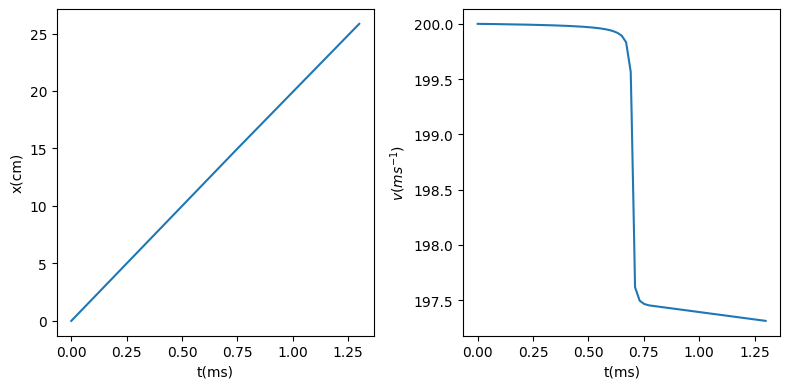

In [21]:
fig,ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(np.array(t_span)*t0*1e3,np.array(x_t)*x0)
ax[0].set_xlabel('t(ms)')
ax[0].set_ylabel('x(cm)')
ax[1].plot(np.array(t_span)*t0*1e3,np.array(v_t)*vc)
ax[1].set_xlabel('t(ms)')
ax[1].set_ylabel('v(ms^-1)')
#ax[1].set_yticks(np.arange(600,800 , 200/10))
ax[1].set_ylabel('$v(ms^{-1})$')
plt.tight_layout()

In [21]:
velocities = np.random.normal(v_a, sd, 100)
x_n = []
v_n = []
for j in velocities:   
    t_max = 0.03/t0
    t_span = np.linspace(0,t_max,1000)
    x_t = []
    v_t = []
    v_0 = j/vc
    v_ind = list(np.array(v))
    x_ind = list(np.array(x))
    s = 0
    di = 0
    dt  =  0 
    for i in range(len(t_span)):
        dt = t_span[i] - di
        
        c = v_ind.index(find_nearest_value(v_ind,v_0))

        d = x_ind.index(find_nearest_value(x_ind,s))

        a = ((rateeq.profile['Fx'].F[0][c][d]))/mass

        s = (1/2)*a*(dt**2) + v_0*dt + s

        v_0 = v_0 + a*dt

        x_t.append(s)

        v_t.append(v_0) 

        di = t_span[i]
        
    x_n.append(x_t)
    v_n.append(v_t)

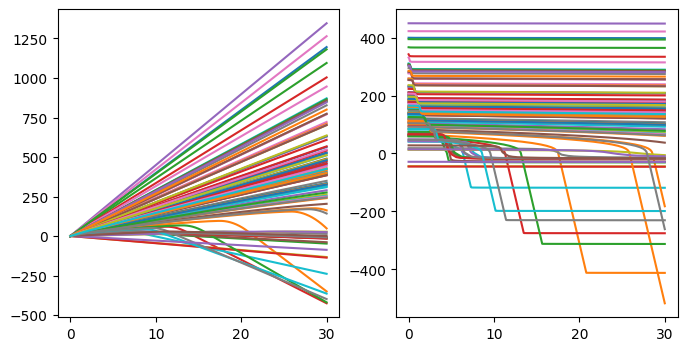

In [22]:
fig,ax = plt.subplots(1, 2, figsize=(8, 4))
for i in x_n:
    ax[0].plot(np.array(t_span)*t0*1e3,np.array(i)*x0)
    ax[1].plot(np.array(t_span)*t0*1e3,np.array(v_n[x_n.index(i)])*vc)

In [23]:
c = 0 
for i in v_n:
    if i[0] > 0:
        pos = v_t[x_t.index(find_nearest_value(x_t,l))]*x0
        if abs(pos*vc)  < 10:
            print(pos*vc)
            c+=1

c

0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.0009185452023026577
0.00091854

97

In [24]:
pos_num = [num for num in velocities if num > 0]
len(pos_num)


97

In [26]:
L

30

In [25]:
max(vel)

649.839748798332